     Простая bilstm с двумя плотными слоями. В качестве входных данных использовались последовательности длинной от 5 до 30 символов и предсказывался следующий символ, те бралась только информация слева.

`(train 0.41, val 0.415, test 0.41)`
`(эпох 160, батч 200)`

### Libraries

In [1]:
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, Input, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import categorical_accuracy
from keras.backend.tensorflow_backend import set_session
from keras import backend as K

import tensorflow as tf
tf.set_random_seed(42)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
curruser = os.environ.get('USER')

import sys
sys.path.append('./src')
from PreprocInput import preproc_

import numpy as np
import random
from tqdm import tqdm
import pandas as pd
import csv

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from pylab import rcParams
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

Using TensorFlow backend.


### Set GPU

In [2]:
with K.tf.device('/GPU:0'):
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    session = tf.Session(config=config)
    K.set_session(session)

### Secondary functions

In [3]:
def plot_metrics(history):
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.figure()
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

In [4]:
def confusion_matrix_heatmap(y_true, y_pred):
    '''
    Построение Confusion matrix (матрицы ошибок)

    Parameters
    ----------
    y_test: pandas.Series, numpy.array
        Целевая для обучающего набора
    y_pred: pandas.Series, numpy.array
        Значения целевой переменной, предсказанные классификатором
    '''
    rcParams['figure.figsize'] = 6, 4
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Greens')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Load dataset and preproc

In [5]:
data = pd.read_csv('./data/LeftWrap_5to30.csv', sep=';')
data.head(5)

,seq,label
0,ACGGCTGGAGCCCATGTTCAGCATGAAAAC,A
1,TAAATTTCTGGATGGCAATGAAATGACATT,A
2,TCCACTTGGCAGCCAAATATGGCCAGACAA,A
3,CGGAGGAGAGCACCGAGCCCCTGAGTGAGG,A
4,GGACCACATTTGGGGAGCTTGCCATTTTAT,A


In [6]:
chars = sorted(list(set(data.label.values)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
indices_char

{0: 'A', 1: 'C', 2: 'G', 3: 'T'}

In [8]:
MAXSEQLEN = max(map(len, data.seq.values))

X, y = preproc_.get_input_array(data.seq.values, data.label.values, MAXSEQLEN, chars, char_indices)
X.shape, y.shape

((3351352, 30, 4), (3351352, 4))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Build model: BiLSTM

In [16]:
def bidirectional_lstm_model(seq_length, vocab_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=128, activation="tanh", dropout=0.2, recurrent_dropout=0.2),
                            input_shape=(seq_length, vocab_size)))
    model.add(Dense(units=128, activation='tanh'))
    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

model = bidirectional_lstm_model(MAXSEQLEN, len(chars))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 256)               136192    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 169,604
Trainable params: 169,604
Non-trainable params: 0
_________________________________________________________________


In [ ]:
BATCH_SIZE = 200
n_epochs = 160

path = './same_/BILSTM.h5'

callbacks=[EarlyStopping(patience=10, monitor='val_loss'),
                 ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)]

history = model.fit(X_train, y_train,
                     batch_size=BATCH_SIZE,
                     shuffle=True,
                     epochs=n_epochs,
                     callbacks=callbacks,
                     validation_split=0.2).history

Instructions for updating:
Use tf.cast instead.
Train on 2144864 samples, validate on 536217 samples
Epoch 1/160
2144864/2144864 [==============================] - 1491s 695us/step - loss: 1.3263 - acc: 0.3512 - val_loss: 1.3055 - val_acc: 0.3719

Epoch 00001: val_loss improved from inf to 1.30547, saving model to ./same_/BILSTM.h5
Epoch 2/160
2144864/2144864 [==============================] - 1490s 695us/step - loss: 1.3082 - acc: 0.3682 - val_loss: 1.2987 - val_acc: 0.3772

Epoch 00002: val_loss improved from 1.30547 to 1.29866, saving model to ./same_/BILSTM.h5
Epoch 3/160
2144864/2144864 [==============================] - 1491s 695us/step - loss: 1.3015 - acc: 0.3740 - val_loss: 1.2963 - val_acc: 0.3789

Epoch 00003: val_loss improved from 1.29866 to 1.29631, saving model to ./same_/BILSTM.h5
Epoch 4/160
   4200/2144864 [..............................] - ETA: 23:53 - loss: 1.2972 - acc: 0.3783

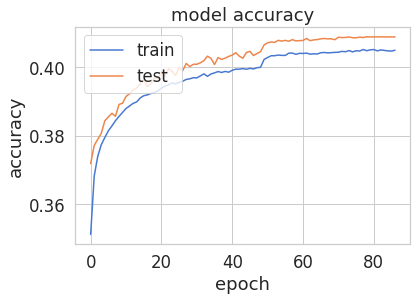

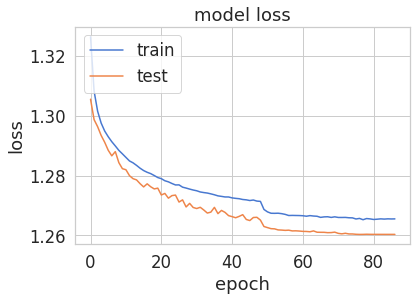

In [19]:
plot_metrics(history)

# OOB validation

In [23]:
model = load_model(path)

In [20]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

y_true = y_test.argmax(axis=-1)

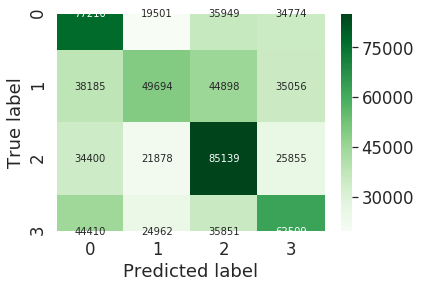

In [21]:
confusion_matrix_heatmap(y_true, y_pred)

In [22]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.46      0.43    167434
           1       0.43      0.30      0.35    167833
           2       0.42      0.51      0.46    167272
           3       0.40      0.37      0.38    167732

    accuracy                           0.41    670271
   macro avg       0.41      0.41      0.41    670271
weighted avg       0.41      0.41      0.41    670271

